# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [2]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

mkdir: cannot create directory ‘cifar10’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  1682k      0  0:01:38  0:01:38 --:--:-- 1580k91k      0  0:01:23  0:00:18  0:01:05 1519k01:37  0:00:01 1838k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [82]:
from scipy.cluster.vq import whiten

In [3]:
from cifar import load_CIFAR10

plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

Преобразуем картинки. Не вполне знаю, что это делает, но в статьях рекомендуют

In [91]:
X_all = whiten(np.vstack([X_train, X_test]))

In [93]:
X_train, X_test = X_all[:len(X_train)], X_all[len(X_train):]

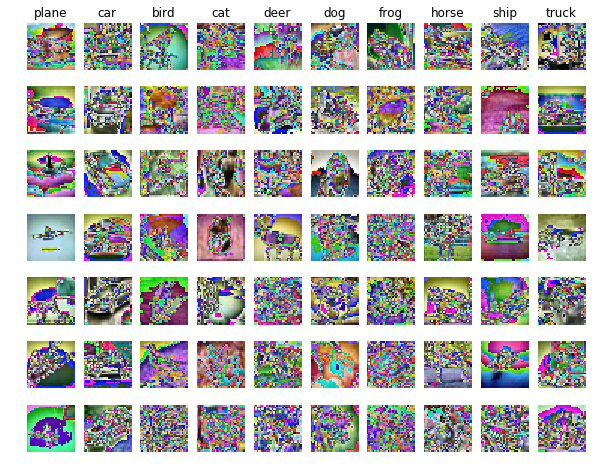

In [96]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((X_train[idx]).transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

Я пытался повторить вот эту (https://arxiv.org/pdf/1611.04905.pdf) сеть (точнее не ее, а одну часть, но там даже без смешивания учатся на 92), но она почему-то училась на ~81. Пришлось подабавлять батчнормов, увелчить свертки, добавить еще дропаутов

In [97]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

In [98]:
import lasagne.layers as ll
import lasagne.layers.dnn as lld

def conv(net, **kwargs):
    kwargs['nonlinearity'] = None
    net = lld.Conv2DDNNLayer(net, **kwargs)
    net = lld.BatchNormDNNLayer(net)
    net = ll.NonlinearityLayer(net, lld.nonlinearities.leaky_rectify)
    return net

In [99]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
 
net = conv(net, num_filters=128, pad=1, filter_size=(3, 3))
net = conv(net, num_filters=128, pad=1, filter_size=(3, 3))

net = lld.MaxPool2DDNNLayer(net, pool_size=(2, 2), stride=2)
net = ll.DropoutLayer(net, p=0.25)
 
net = conv(net, num_filters=256, pad=1, filter_size=(3, 3))
net = conv(net, num_filters=256, pad=1, filter_size=(3, 3))


net = lld.MaxPool2DDNNLayer(net, pool_size=(2, 2), stride=2)
net = ll.DropoutLayer(net, p=0.25)
 
net = conv(net, num_filters=512, pad=1, filter_size=(3, 3))
net = conv(net, num_filters=512, pad=1, filter_size=(3, 3))
net = ll.DropoutLayer(net, p=0.25)
net_ = conv(net, num_filters=512, pad=1, filter_size=(3, 3))
net_ = conv(net, num_filters=512, pad=1, filter_size=(3, 3))

net = lld.MaxPool2DDNNLayer(net, pool_size=(2, 2), stride=2)
net = ll.DropoutLayer(net, p=0.25)

net = ll.DenseLayer(net, num_units=2048, nonlinearity=lld.nonlinearities.rectify)
net = ll.DropoutLayer(net, p=0.25)
net = ll.DenseLayer(net, num_units=2048, nonlinearity=lld.nonlinearities.rectify)
net = ll.DropoutLayer(net, p=0.5)
net = ll.DenseLayer(net,num_units = 10, nonlinearity=lld.nonlinearities.softmax)

y_predicted = lasagne.layers.get_output(net)
y_pr = lasagne.layers.get_output(net, deterministic=True)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)
 
import requests
def send(text):
    # тут функция отправки сообщений в телеграм (чтобы следить за сеточкой даже когда ты в отъезде), 
    # при сдаче я потер токен и чат id
    requests.get("https://api.telegram.org/botTOKEN/sendMessage?chat_id=CHAT_ID&text=%s" % text)
 
 
# accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
ac_pr = lasagne.objectives.categorical_accuracy(y_pr, target_y).mean()
 


[W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, W, b]


In [100]:
eta = theano.shared(lasagne.utils.floatX(1e-3))
updates = lasagne.updates.adam(loss, all_weights, learning_rate=eta)

 
train_fun = theano.function([input_X, target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)
ac_fun = theano.function([input_X, target_y], ac_pr, allow_input_downcast=True)

### Вот и всё, пошли её учить

Тут я стырил аугментацию из lasagne recipies

In [103]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc - SM, targets[excerpt]
#     if augment:
#         for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
#             excerpt = slice(start_idx, start_idx + batchsize)
#             # as in paper : 
#             # pad feature arrays with 4 pixels on each side
#             # and do random cropping of 32x32
#             padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
#             random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
#             crops = np.random.random_integers(0,high=8,size=(batchsize,2))
#             for r in range(batchsize):
#                 random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
#             inp_exc = random_cropped
#         else:
#             inp_exc = inputs[excerpt]
#         yield inp_exc, targets[excerpt]

# Процесс обучения

In [104]:
send("START")

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [107]:
X_val, y_val = X_val - SM, y_val

In [113]:
#эта ячейка появилась не сразу, а после многих запусков
eta.set_value(lasagne.utils.floatX(eta.get_value() * 5))

In [ ]:
import time

num_epochs = 1000 #количество проходов по данным

batch_size = 200 #размер мини-батча

for epoch in range(num_epochs):
    #говорят, лернинг рейт полезно уменьшать
    if (epoch % 10 == 0 and epoch > 10):
        eta.set_value(lasagne.utils.floatX(eta.get_value() / 2))
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_t, y_t,batch_size,augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    send("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    send("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    send("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    send("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

/usr/lib/python3.4/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 1000 took 136.612s
  training loss (in-iteration):		0.015654
  train accuracy:		99.48 %
  validation accuracy:		86.87 %


Не верьте, что это первая эпоха и тут всего одна. На самом деле прошло много, много эпох, потом я стопил, потом исправлял лернинг рейт, потом снова запускал, оставлял на ночь, вырубал ноут, так что в итоге история подзатерялась. Если интересно, могу показать историю обучения из телеграма. Валидэйшн остановился где-то на 87.88 процентах что-ли. Сумарно я запустил под 1000 эпох, я думаю (разной степени сложности), эту сеть тренил где-то 200 эпох наверное 

In [118]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 1000):
    inputs, targets = batch
    acc = ac_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		90.23 %
Нужно больше магии!


На тесте скор вырос -- приятная неожиданность. Однако, недостаточно. Эх

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 